# Text classification with BERT in PyTorch

2018 was an exciting year for Natural Language Processing. One of the most promising evolutions was the breakthrough of transfer learning. Models like Elmo Embeddings, ULMFit and BERT allow us to pre-train a neural network on a large collection of unlabelled texts. Thanks to an auxiliary task such as language modelling, these models are able to learn a lot about the syntax, semantics and morphology of a language. This knowledge can be put to good use: because they already know so much about language use, these models need much less labelled data to reach state-of-the-art performance on other tasks, such as text classification, sequence labelling or question answering. 

One of the most popular models is [BERT](https://arxiv.org/abs/1810.04805), developed by researchers at Google. BERT stands for Bidirectional Encoder Representations from Transformers. It uses the Transformer architecture to pretrain bidirectional "language models". By adding just one task-specific output layer, it is possible to use such a pre-trained BERT model on a variety of NLP tasks. In this notebook, we're going to investigate its performance on a sentiment analysis task, where the task is to predict whether a review is positive or negative. Unfortunately, we can't share the data, but you can easily plug in your own.

## Data

Let's first get our data. Our corpus is a simple newline-delimited json file with a list of product reviews from Amazon. It's a subset of the huge [Amazon review corpus](https://nijianmo.github.io/amazon/index.html) that has been so popular in sentiment analysis. Each of the documents in our file is a dictionary with a "title", "body" and "rating". We'll try to build a model that can predict the rating from the title and the body.

In [1]:
CORPUS_PATH = "data/sentiment_analysis/review_corpus_en.ndjson"

First, we split up the data into a train, development and test portion. 

In [2]:
import ndjson
from sklearn.model_selection import train_test_split

with open(CORPUS_PATH) as i:
    data = ndjson.load(i)
    
texts = [" ".join([doc["title"], doc["body"]]) for doc in data]
labels = [doc["rating"] for doc in data]
    
rest_texts, test_texts, rest_labels, test_labels = train_test_split(texts, labels, test_size=0.1, random_state=1)
train_texts, dev_texts, train_labels, dev_labels = train_test_split(rest_texts, rest_labels, test_size=0.1, random_state=1)

print("Train size:", len(train_texts))
print("Dev size:", len(dev_texts))
print("Test size:", len(test_texts))

Train size: 2430
Dev size: 270
Test size: 300


Next, we need to determine the number of labels in our data. We'll map each of these labels to an index. In our sentiment analysis example, there are three labels: positive (all 4-star and 5-star reviews), mixed (all 3-star reviews) and negative (all 2-star and 1-star reviews).

In [3]:

target_names = list(set(labels))
label2idx = {label: idx for idx, label in enumerate(target_names)}
print(label2idx)

{'mixed': 0, 'neg': 1, 'pos': 2}


## Baseline

Let's train a baseline model for our task. In this way we have something to compare BERT's performance to. As our baseline, we choose a simple Logistic Regression classifier from Scikit-learn. We use grid search to find the optimal settings for its hyperparameter _C_. At the end of this process, we find that our best baseline classifier obtains an accuracy of 62.67%.

In [4]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('lr', LogisticRegression(multi_class="ovr"))
])

parameters = {'lr__C': [0.1, 0.5, 1, 2, 5, 10, 100, 1000]}

best_classifier = GridSearchCV(pipeline, parameters, cv=5, verbose=1)
best_classifier.fit(train_texts, train_labels)
best_predictions = best_classifier.predict(test_texts)

baseline_accuracy = np.mean(best_predictions == test_labels)
print("Baseline accuracy:", baseline_accuracy)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:   13.0s finished


Baseline accuracy: 0.6266666666666667


## BERT

Now we move to BERT. The team at [HuggingFace](https://github.com/huggingface) has developed a great Python library, [transformers](https://github.com/huggingface/transformers), with implementations of an impressive number of transfer-learning models in PyTorch and Tensorflow. It makes finetuning these models pretty easy. Let's first install this library. 

In [5]:
!pip install transformers

You should consider upgrading via the 'pip install --upgrade pip' command.


You really need a GPU to finetune BERT. Still, to make sure this code runs on any machine we'll let PyTorch determine whether a GPU is available.

In [6]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Initializing a model

Google has made available a range of BERT models for us to experiment with. For English, there is a choice between three models: `bert-large-uncased` is the largest model that will likely give the best results. Its smaller siblings are `bert-base-uncased` and `bert-base-cased`, which are more practical to work with. For Chinese there is `bert-base-chinese`, and for the other languages we have `bert-base-multilingual-uncased` and `bert-base-multilingual-cased`. 

Uncased means that the training text has been lowercased and accents have been stripped. This is usually better, unless you know that case information is important for your task, such as with Named Entity Recognition. 

In our example, we're going to investigate sentiment analysis on English. We'll therefore use the English BERT-base model.

In [7]:
BERT_MODEL = "bert-base-uncased"

Each model comes with its own tokenizer. This tokenizer splits texts into [word pieces](https://github.com/google/sentencepiece). In addition, we'll tell the tokenizer it should lowercase the text, as we're going to work with the uncased model. 

In [8]:
from transformers.tokenization_bert import BertTokenizer

tokenizer = BertTokenizer.from_pretrained(BERT_MODEL)

/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passi

A full BERT model consists of a common, pretrained core, and an extension on top that depends on the particular NLP task. After all, the output of a sequence classification model, where we have just one prediction for every sequence, looks very different from the output of a sequence labelling or question answering model. As we're looking at sentiment classification, we're going to use the pretrained BERT model with a final layer for sequence classification on top.

In [9]:
from transformers.modeling_bert import BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained(BERT_MODEL, num_labels = len(label2idx))
model.to(device)

I1029 17:22:03.102142 140454475781952 configuration_utils.py:151] loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-config.json from cache at /home/yves/.cache/torch/transformers/4dad0251492946e18ac39290fcfe91b89d370fee250efe9521476438fe8ca185.bf3b9ea126d8c0001ee8a1e8b92229871d06d36d8808208cc2449280da87785c
I1029 17:22:03.103991 140454475781952 configuration_utils.py:168] Model config {
  "attention_probs_dropout_prob": 0.1,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "num_labels": 3,
  "output_attentions": false,
  "output_hidden_states": false,
  "output_past": true,
  "pruned_heads": {},
  "torchscript": false,
  "type_vocab_size": 2,
  "use_bfloat16": false,
  "vocab_size": 30522
}

I1029 17:22:03.594896

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm(torch.Size([768]), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm(torch.Size([768]), eps=1e-12, elementwise_aff

### Preparing the data

Next we need to prepare our data for BERT. We'll present every document as an InputFeatures object, which contains all the information BERT needs: 

- a list of input ids. Take a look at the logging output to see what this means. Every text has been split up into subword units, which are shared between all the languages in the multilingual model. When a word appears frequently enough in a combined corpus of all languages, it is kept intact. If it is less frequent, it is split up into subword units that do occur frequently enough across all languages. This allows our model to process every text as a sequence of strings from a finite vocabulary of limited size. Note also the first `[CLS]` token. This token is added at the beginning of every document. The vector at the output of this token will be used by the BERT model for its sequence classification tasks: it serves as the input of the final, task-specific part of the neural network.
- the input mask: the input mask tells the model which parts of the input it should look at and which parts it should ignore. In our example, we have made sure that every text has a length of 100 tokens. This means that some texts will be cut off after 100 tokens, while others will have to be padded with extra tokens. In this latter case, these padding tokens will receive a mask value of 0, which means BERT should not take them into account for its classification task. 
- the segment_ids: some NLP task take several sequences as input. This is the case for question answering, natural language inference, etc. In this case, the segment ids tell BERT which sequence every token belongs to. In a text classification task like ours, however, there's only one segment, so all the input tokens receive segment id 0.
- the label id: the id of the label for this document.

In [10]:
import logging
import numpy as np

logging.basicConfig(format = '%(asctime)s - %(levelname)s - %(name)s -   %(message)s',
                    datefmt = '%m/%d/%Y %H:%M:%S',
                    level = logging.INFO)
logger = logging.getLogger(__name__)

MAX_SEQ_LENGTH=100

class BertInputItem(object):
    """A single set of features of data."""

    def __init__(self, text, input_ids, input_mask, segment_ids, label_id):
        self.text = text
        self.input_ids = input_ids
        self.input_mask = input_mask
        self.segment_ids = segment_ids
        self.label_id = label_id
        

def convert_examples_to_inputs(example_texts, example_labels, label2idx, max_seq_length, tokenizer, verbose=0):
    """Loads a data file into a list of `InputBatch`s."""
    
    input_items = []
    examples = zip(example_texts, example_labels)
    for (ex_index, (text, label)) in enumerate(examples):

        # Create a list of token ids
        input_ids = tokenizer.encode(f"[CLS] {text} [SEP]")
        if len(input_ids) > max_seq_length:
            input_ids = input_ids[:max_seq_length]

        # All our tokens are in the first input segment (id 0).
        segment_ids = [0] * len(input_ids)

        # The mask has 1 for real tokens and 0 for padding tokens. Only real
        # tokens are attended to.
        input_mask = [1] * len(input_ids)

        # Zero-pad up to the sequence length.
        padding = [0] * (max_seq_length - len(input_ids))
        input_ids += padding
        input_mask += padding
        segment_ids += padding

        assert len(input_ids) == max_seq_length
        assert len(input_mask) == max_seq_length
        assert len(segment_ids) == max_seq_length

        label_id = label2idx[label]

        input_items.append(
            BertInputItem(text=text,
                          input_ids=input_ids,
                          input_mask=input_mask,
                          segment_ids=segment_ids,
                          label_id=label_id))

        
    return input_items

train_features = convert_examples_to_inputs(train_texts, train_labels, label2idx, MAX_SEQ_LENGTH, tokenizer, verbose=0)
dev_features = convert_examples_to_inputs(dev_texts, dev_labels, label2idx, MAX_SEQ_LENGTH, tokenizer)
test_features = convert_examples_to_inputs(test_texts, test_labels, label2idx, MAX_SEQ_LENGTH, tokenizer)

W1029 17:22:08.038088 140454475781952 tokenization_utils.py:677] Token indices sequence length is longer than the specified maximum sequence length for this model (532 > 512). Running this sequence through the model will result in indexing errors
W1029 17:22:08.073059 140454475781952 tokenization_utils.py:677] Token indices sequence length is longer than the specified maximum sequence length for this model (613 > 512). Running this sequence through the model will result in indexing errors
W1029 17:22:08.109563 140454475781952 tokenization_utils.py:677] Token indices sequence length is longer than the specified maximum sequence length for this model (1380 > 512). Running this sequence through the model will result in indexing errors
W1029 17:22:08.116200 140454475781952 tokenization_utils.py:677] Token indices sequence length is longer than the specified maximum sequence length for this model (593 > 512). Running this sequence through the model will result in indexing errors
W1029 17:22

W1029 17:22:08.831181 140454475781952 tokenization_utils.py:677] Token indices sequence length is longer than the specified maximum sequence length for this model (585 > 512). Running this sequence through the model will result in indexing errors
W1029 17:22:08.878458 140454475781952 tokenization_utils.py:677] Token indices sequence length is longer than the specified maximum sequence length for this model (3767 > 512). Running this sequence through the model will result in indexing errors
W1029 17:22:08.890501 140454475781952 tokenization_utils.py:677] Token indices sequence length is longer than the specified maximum sequence length for this model (1023 > 512). Running this sequence through the model will result in indexing errors
W1029 17:22:08.902592 140454475781952 tokenization_utils.py:677] Token indices sequence length is longer than the specified maximum sequence length for this model (632 > 512). Running this sequence through the model will result in indexing errors
W1029 17:2

W1029 17:22:09.572366 140454475781952 tokenization_utils.py:677] Token indices sequence length is longer than the specified maximum sequence length for this model (1059 > 512). Running this sequence through the model will result in indexing errors
W1029 17:22:09.633646 140454475781952 tokenization_utils.py:677] Token indices sequence length is longer than the specified maximum sequence length for this model (1471 > 512). Running this sequence through the model will result in indexing errors
W1029 17:22:09.662027 140454475781952 tokenization_utils.py:677] Token indices sequence length is longer than the specified maximum sequence length for this model (719 > 512). Running this sequence through the model will result in indexing errors
W1029 17:22:09.686250 140454475781952 tokenization_utils.py:677] Token indices sequence length is longer than the specified maximum sequence length for this model (1570 > 512). Running this sequence through the model will result in indexing errors
W1029 17:

W1029 17:22:10.485311 140454475781952 tokenization_utils.py:677] Token indices sequence length is longer than the specified maximum sequence length for this model (521 > 512). Running this sequence through the model will result in indexing errors
W1029 17:22:10.504518 140454475781952 tokenization_utils.py:677] Token indices sequence length is longer than the specified maximum sequence length for this model (513 > 512). Running this sequence through the model will result in indexing errors
W1029 17:22:10.519095 140454475781952 tokenization_utils.py:677] Token indices sequence length is longer than the specified maximum sequence length for this model (608 > 512). Running this sequence through the model will result in indexing errors
W1029 17:22:10.531493 140454475781952 tokenization_utils.py:677] Token indices sequence length is longer than the specified maximum sequence length for this model (640 > 512). Running this sequence through the model will result in indexing errors
W1029 17:22:

W1029 17:22:11.519425 140454475781952 tokenization_utils.py:677] Token indices sequence length is longer than the specified maximum sequence length for this model (1599 > 512). Running this sequence through the model will result in indexing errors
W1029 17:22:11.548164 140454475781952 tokenization_utils.py:677] Token indices sequence length is longer than the specified maximum sequence length for this model (1142 > 512). Running this sequence through the model will result in indexing errors
W1029 17:22:11.561769 140454475781952 tokenization_utils.py:677] Token indices sequence length is longer than the specified maximum sequence length for this model (923 > 512). Running this sequence through the model will result in indexing errors
W1029 17:22:11.595750 140454475781952 tokenization_utils.py:677] Token indices sequence length is longer than the specified maximum sequence length for this model (1170 > 512). Running this sequence through the model will result in indexing errors
W1029 17:

Finally, we're going to initialize a data loader for our training, development and testing data. This data loader puts all our data in tensors and will allow us to iterate over them during training.

In [11]:
from torch.utils.data import TensorDataset, DataLoader, SequentialSampler

def get_data_loader(features, max_seq_length, batch_size, shuffle=True): 

    all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
    all_input_mask = torch.tensor([f.input_mask for f in features], dtype=torch.long)
    all_segment_ids = torch.tensor([f.segment_ids for f in features], dtype=torch.long)
    all_label_ids = torch.tensor([f.label_id for f in features], dtype=torch.long)
    data = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_label_ids)

    dataloader = DataLoader(data, shuffle=shuffle, batch_size=batch_size)
    return dataloader

BATCH_SIZE = 16

train_dataloader = get_data_loader(train_features, MAX_SEQ_LENGTH, BATCH_SIZE, shuffle=True)
dev_dataloader = get_data_loader(dev_features, MAX_SEQ_LENGTH, BATCH_SIZE, shuffle=False)
test_dataloader = get_data_loader(test_features, MAX_SEQ_LENGTH, BATCH_SIZE, shuffle=False)

### Evaluation method

Now it's time to write our evaluation method. This method takes as input a model and a data loader with the data we would like to evaluate on. For each batch, it computes the output of the model and the loss. We use this output to compute the obtained precision, recall and F-score. During training, we will print the simple numbers. When we evaluate on the test set, we will output a full classification report.

In [12]:
def evaluate(model, dataloader):

    eval_loss = 0
    nb_eval_steps = 0
    predicted_labels, correct_labels = [], []

    for step, batch in enumerate(tqdm(dataloader, desc="Evaluation iteration")):
        batch = tuple(t.to(device) for t in batch)
        input_ids, input_mask, segment_ids, label_ids = batch

        with torch.no_grad():
            tmp_eval_loss, logits = model(input_ids, attention_mask=input_mask,
                              token_type_ids=segment_ids, labels=label_ids)

        outputs = np.argmax(logits.to('cpu'), axis=1)
        label_ids = label_ids.to('cpu').numpy()
        
        predicted_labels += list(outputs)
        correct_labels += list(label_ids)
        
        eval_loss += tmp_eval_loss.mean().item()
        nb_eval_steps += 1

    eval_loss = eval_loss / nb_eval_steps
    
    correct_labels = np.array(correct_labels)
    predicted_labels = np.array(predicted_labels)
        
    return eval_loss, correct_labels, predicted_labels

### Training

Now it's time to start training. We're going to use the Adam optimizer with a learning rate of 5e-5, and train for a maximum of 100 epochs. Here are some additional things to note: 

- Gradient Accumulation allows us to keep our batches small enough to fit into the memory of our GPU, while getting the advantages of using larger batch sizes. In practice, it means we sum the gradients of several batches, before we perform a step of gradient descent. 
- Our learning rate is going to vary as a function of the training progress. First, during the warm-up stage, we're going to start with a small learning rate, which gradually increases. After the warm-up stage, we let the learning rate increase suddenly, and then decay linearly.

In [13]:
from transformers.optimization import AdamW, WarmupLinearSchedule

GRADIENT_ACCUMULATION_STEPS = 1
NUM_TRAIN_EPOCHS = 100
LEARNING_RATE = 5e-5
WARMUP_PROPORTION = 0.1
MAX_GRAD_NORM = 5

num_train_steps = int(len(train_dataloader.dataset) / BATCH_SIZE / GRADIENT_ACCUMULATION_STEPS * NUM_TRAIN_EPOCHS)
num_warmup_steps = int(WARMUP_PROPORTION * num_train_steps)

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]

optimizer = AdamW(optimizer_grouped_parameters, lr=LEARNING_RATE, correct_bias=False)
scheduler = WarmupLinearSchedule(optimizer, warmup_steps=num_warmup_steps, t_total=num_train_steps)


We're finally ready to train our model. At each epoch, we're going to train it on our training data and evaluate it on the development data. We keep a history of the loss, and stop training when the loss on the development set doesn't improve for a certain number of steps (we call this number our `patience`). Whenever the development loss of our model improves, we save it. 

In [14]:
import torch
import os
from tqdm import trange
from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import classification_report, precision_recall_fscore_support

OUTPUT_DIR = "/tmp/"
MODEL_FILE_NAME = "pytorch_model.bin"
PATIENCE = 2

model.train()
loss_history = []
for _ in trange(int(NUM_TRAIN_EPOCHS), desc="Epoch"):
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0
    for step, batch in enumerate(tqdm(train_dataloader, desc="Training iteration")):
        batch = tuple(t.to(device) for t in batch)
        input_ids, input_mask, segment_ids, label_ids = batch

        outputs = model(input_ids, attention_mask=input_mask, token_type_ids=segment_ids, labels=label_ids)
        loss = outputs[0]

        if GRADIENT_ACCUMULATION_STEPS > 1:
            loss = loss / GRADIENT_ACCUMULATION_STEPS

        loss.backward()

        tr_loss += loss.item()

        if (step + 1) % GRADIENT_ACCUMULATION_STEPS == 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(),
                                           MAX_GRAD_NORM)  
            
            scheduler.step()
            optimizer.step()
            optimizer.zero_grad()

    dev_loss, _, _ = evaluate(model, dev_dataloader)
    
    print("Loss history:", loss_history)
    print("Dev loss:", dev_loss)
    
    if len(loss_history) == 0 or dev_loss < min(loss_history):
        model_to_save = model.module if hasattr(model, 'module') else model
        output_model_file = os.path.join(OUTPUT_DIR, MODEL_FILE_NAME)
        torch.save(model_to_save.state_dict(), output_model_file)
    
    if len(loss_history) > 0 and dev_loss > max(loss_history[-PATIENCE:]): 
        print("No improvement on development set. Finish training.")
        break
        
    
    loss_history.append(dev_loss)

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]


Loss history: []
Dev loss: 0.9029208982692045


Epoch:   1%|          | 1/100 [00:34<56:09, 34.04s/it]


Loss history: [0.9029208982692045]
Dev loss: 0.6848114693866056


Epoch:   2%|▏         | 2/100 [01:08<55:39, 34.07s/it]


Loss history: [0.9029208982692045, 0.6848114693866056]
Dev loss: 0.6677473853616154


Epoch:   3%|▎         | 3/100 [01:42<55:10, 34.13s/it]


Loss history: [0.9029208982692045, 0.6848114693866056, 0.6677473853616154]
Dev loss: 0.8759423248908099
No improvement on development set. Finish training.


### Evaluation

Let's now evaluate the model on some documents it has never seen. We'll load our best model and have it predict the labels for all documents in our data. We'll compute its precision, recall and F-score for the training, development and test set and print a full classification report for the test set.

In [15]:
model_state_dict = torch.load(os.path.join(OUTPUT_DIR, MODEL_FILE_NAME), map_location=lambda storage, loc: storage)
model = BertForSequenceClassification.from_pretrained(BERT_MODEL, state_dict=model_state_dict, num_labels = len(target_names))
model.to(device)

model.eval()

_, train_correct, train_predicted = evaluate(model, train_dataloader)
_, dev_correct, dev_predicted = evaluate(model, dev_dataloader)
_, test_correct, test_predicted = evaluate(model, test_dataloader)

print("Training performance:", precision_recall_fscore_support(train_correct, train_predicted, average="micro"))
print("Development performance:", precision_recall_fscore_support(dev_correct, dev_predicted, average="micro"))
print("Test performance:", precision_recall_fscore_support(test_correct, test_predicted, average="micro"))

bert_accuracy = np.mean(test_predicted == test_correct)

print(classification_report(test_correct, test_predicted, target_names=target_names))

I1029 17:24:29.311650 140454475781952 configuration_utils.py:151] loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-config.json from cache at /home/yves/.cache/torch/transformers/4dad0251492946e18ac39290fcfe91b89d370fee250efe9521476438fe8ca185.bf3b9ea126d8c0001ee8a1e8b92229871d06d36d8808208cc2449280da87785c
I1029 17:24:29.314333 140454475781952 configuration_utils.py:168] Model config {
  "attention_probs_dropout_prob": 0.1,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "num_labels": 3,
  "output_attentions": false,
  "output_hidden_states": false,
  "output_past": true,
  "pruned_heads": {},
  "torchscript": false,
  "type_vocab_size": 2,
  "use_bfloat16": false,
  "vocab_size": 30522
}

I1029 17:24:29.769491


Training performance: (0.9102880658436214, 0.9102880658436214, 0.9102880658436214, None)
Development performance: (0.7185185185185186, 0.7185185185185186, 0.7185185185185186, None)
Test performance: (0.7033333333333334, 0.7033333333333334, 0.7033333333333334, None)
             precision    recall  f1-score   support

      mixed       0.65      0.61      0.63       112
        neg       0.66      0.81      0.73        93
        pos       0.83      0.72      0.77        95

avg / total       0.71      0.70      0.70       300



We see that BERT obtains an accuracy of 70.33% on the test data. This is around 8% more than our initial baseline classifier. This confirms that BERT's transfer learning helps us achieve significantly higher accuracies for small datasets.

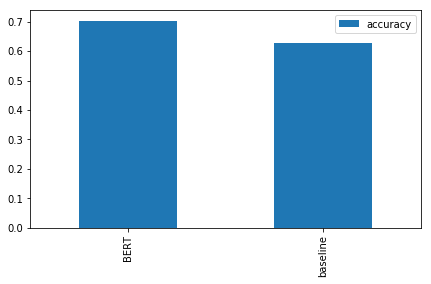

In [16]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame({"accuracy": {"baseline": baseline_accuracy, "BERT": bert_accuracy}})
plt.rcParams['figure.figsize'] = (7,4)
df.plot(kind="bar")